In [1]:
from collections import namedtuple
from bbchallenge import *
from PIL import Image
from typing import List, Dict
import copy
import drawsvg

## SVG view

In [2]:
def tm_trace_to_text(machine, nb_steps):
    trace = get_tm_trace(machine, nb_steps)
    
    min_pos, max_pos = get_trace_extreme_pos(trace)
    
    for tape, state, head_pos in trace:
        print(chr(ord("A")+state), end=" ")
        for pos in range(min_pos, max_pos+1):
            if pos == head_pos:
                print(">", end="")
            else:
                print(" ", end="")

            if pos not in tape:
                print("#", end=" ")
            else:
                print(tape[pos], end=" ")
        print()
        
    print(min_pos, max_pos)

In [3]:
def get_tm_trace(machine, nb_steps, initial_step=0):
    tape = {}
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    
    tapes = [(copy.copy(tape),0,0)]
    
    curr_step = 0
    for row in range(1,nb_steps+initial_step):
        last_pos = curr_pos
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        curr_step += 1
        
        if curr_step >= initial_step:
            tapes.append((copy.copy(tape),curr_state,curr_pos))
       
    return tapes

def get_trace_extreme_pos(trace):
    min_pos = 0
    max_pos = 0
    for tape,_,_ in trace:
        if len(tape.keys()) == 0:
            continue
        min_pos = min(min_pos,min(tape.keys()))
        max_pos = max(max_pos,max(tape.keys()))
        
    return min_pos, max_pos

StrokeAnnotation = namedtuple('StrokeAnnotation', ('step', 'pos', 'color', 'width'))
def tm_trace_to_svg(machine, nb_steps, initial_step=0, cell_size=16, 
                    debug=False, stroke_annotations:Dict[int,Dict[int,StrokeAnnotation]]={}):
    trace = get_tm_trace(machine, nb_steps, initial_step=initial_step)
    
    min_pos, max_pos = get_trace_extreme_pos(trace)
    tape_size = max_pos-min_pos+1
    
    draw_w = tape_size*cell_size
    draw_h = nb_steps*cell_size
    
    d = drawsvg.Drawing(draw_w, draw_h, origin=(0,0), displayInline=False)
    
    COLOR_WHEEL = [[255, 0, 0],[255, 128, 0],[0, 0, 255],[0, 255, 0],[255, 0, 255],[0, 255, 255],[255, 255, 0]]
    
    def get_cell_rgb_color(tape, state, head_pos, pos):
        if pos == head_pos:
            return COLOR_WHEEL[state]
        if pos not in tape:
            return [90,90,90]
        if tape[pos] == 0:
            return [0,0,0]
        return [255,255,255]
    
    def color_to_svg(color):
        if isinstance(color,str):
            return color
        return f"rgb({color[0]},{color[1]},{color[2]})"
    
    def step_pos_to_svg_coords(step,pos):
        draw_x = (pos-min_pos)*cell_size
        draw_y = step*cell_size
        return draw_x, draw_y
    
    step = 0
    for tape, state, head_pos in trace:
        row_group = drawsvg.Group()
        
        for pos in range(min_pos, max_pos+1):
            color = get_cell_rgb_color(tape, state, head_pos, pos)
            draw_x, draw_y = step_pos_to_svg_coords(step,pos)                
            cell = drawsvg.Rectangle(draw_x, draw_y, cell_size, cell_size,
                                  fill=color_to_svg(color))
            
            row_group.children.append(cell)
        step += 1
        d.append(row_group)
    
    annot_group = drawsvg.Group()
    for stroke_annot in stroke_annotations:
        draw_x, draw_y = step_pos_to_svg_coords(stroke_annot.step,stroke_annot.pos)     
        cell = drawsvg.Rectangle(draw_x,draw_y,cell_size,cell_size, fill="rgba(0,0,0,0)",
                              stroke=color_to_svg(stroke_annot.color),stroke_width=stroke_annot.width)
        annot_group.children.append(cell)
    
    d.append(annot_group)
    if debug:
        d.append(drawsvg.Rectangle(0, 0, cell_size, cell_size, fill="cyan"))
    return d

## Deciding bouncers

In [4]:
TapeExtreme = namedtuple('TapeExtreme', ['side', 'time', 'pos'])

def simulate_and_get_extremes(machine, time_limit = 10000, strict = False):
    
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    min_pos, max_pos = 0,0
    tape_extremes: List[TapeExtreme] = []

    while curr_state != None and curr_time < time_limit:
        
        if not strict:
            if curr_time == 0 or curr_pos <= min_pos:
                min_pos = curr_pos
                tape_extremes.append(TapeExtreme("left",curr_time,curr_pos))

            if curr_time == 0 or curr_pos >= max_pos:
                max_pos = curr_pos
                tape_extremes.append(TapeExtreme("right",curr_time,curr_pos))
        else:
            if curr_time == 0 or curr_pos < min_pos:
                min_pos = curr_pos
                tape_extremes.append(TapeExtreme("left",curr_time,curr_pos))

            if curr_time == 0 or curr_pos > max_pos:
                max_pos = curr_pos
                tape_extremes.append(TapeExtreme("right",curr_time,curr_pos))
            

        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
       
        curr_time += 1
        
    return tape_extremes

In [5]:
def get_local_extremes(extremes):
    to_return = []
    
    for i in range(len(extremes)):
        if i < len(extremes) - 1 and extremes[i].side == extremes[i+1].side:
            continue
        
        to_return.append(extremes[i])
    
    return to_return

In [6]:
bouncers_id = [12785688, 8929416, 76727755, 8179149, 8680193, 10955739, 58057, 10784014, 
                        10750857, 82820597, 9627910, 10788462, 2488210, 14155579, 2712075, 5531970, 
                        9099315, 11323181, 1550671, 8631993, 6686258, 3301037, 9357684, 7260722, 
                        12604461, 7083973, 11685160, 14076871, 10879705, 15439564, 167872, 12112369,
                        2815026, 7762990, 9556263, 9660079, 1828616, 10278087, 2163518, 5747101, 
                        10436913, 400772, 626088, 6251627, 965550, 8759155, 11223826, 10753312, 
                        3467845, 4897489, 9003220, 8570030, 11270715, 27293997, 5699889, 9829009, 
                        59839853, 6170236, 11982212, 7164345, 8189825, 12875376, 12764993, 13199370, 
                        2272659, 4789124, 9105362, 12846440, 40562752, 3336092, 9124284, 6283269, 
                        71791981, 8813622, 11319132, 3405717, 7890444, 86152240, 9562099, 11185189, 
                        153481, 10667540, 69838082, 4139167, 11790195, 6283761, 6040629, 2963361, 
                        11341640, 3133305, 6223673, 9129536, 10884143, 35695274, 5253373, 12304289, 
                        3814868, 10866122, 298605, 6345422, 8192282, 4793378]

In [7]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"
tested_ids = [11270715, 58329156]
m = get_machine_i(DB_PATH,5351821)

In [8]:
extremes = simulate_and_get_extremes(m)
extremes_strict = simulate_and_get_extremes(m, strict=True)
local_extremes = get_local_extremes(extremes)

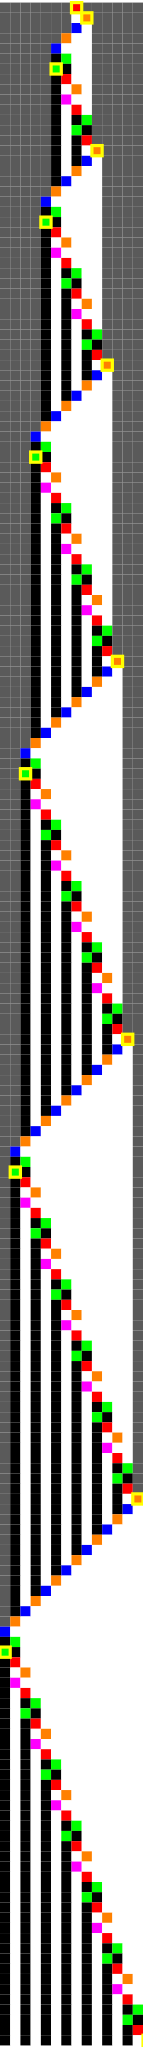

In [9]:
stroke_annotations = []

# for local_extreme in extremes_strict:
#     stroke_annotations.append(StrokeAnnotation(local_extreme.time, local_extreme.pos, "teal", 5))


for local_extreme in local_extremes:
    stroke_annotations.append(StrokeAnnotation(local_extreme.time, local_extreme.pos, "yellow", 5))


tm_trace_to_svg(m,200,debug=False,stroke_annotations=stroke_annotations)

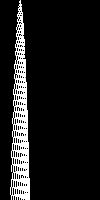

In [10]:
img = tm_trace_to_image(m, origin=0.2, width=500, height=10000, show_head_direction=True).resize((100,200), Image.NEAREST)
img